In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import linear_model
import xgboost as xgb
import matplotlib.ticker
from sklearn import metrics
from sklearn import preprocessing

matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
pd.options.display.max_columns = 100

In [4]:
# df = pd.read_csv("data/block-groups.csv")
#df = pd.read_csv("data/counties_US.csv")
df = pd.read_csv("data/US/counties.csv")
#df = pd.read_csv("data/cities_US.csv") 

In [5]:
df.dropna(axis=0, how='any', inplace=True)
#print(df.iloc[0])
columns = df.columns
renames = {}
for col in columns:
    renames[col] = col.replace('-', '_')
df = df.rename(columns=renames)
df.describe()

,GEOID,year,population,poverty_rate,renter_occupied_households,pct_renter_occupied,median_gross_rent,median_household_income,median_property_value,rent_burden,pct_white,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other,eviction_filings,evictions,eviction_rate,eviction_filing_rate,low_flag,imputed,subbed
count,41299.000000,41299.000000,4.129900e+04,41299.000000,4.129900e+04,41299.000000,41299.000000,41299.000000,4.129900e+04,41299.000000,41299.000000,41299.000000,41299.000000,41299.000000,41299.000000,41299.000000,41299.000000,41299.000000,41299.000000,41299.000000,41299.000000,41299.000000,41299.000000,41299.000000,41299.000000
mean,30928.597956,2008.187753,9.717697e+04,12.410998,1.301934e+04,26.820699,592.652970,42136.557350,1.164624e+05,26.821584,79.966203,8.409063,7.861583,1.186445,0.994529,0.063298,1.431872,0.087025,892.026490,374.336449,1.678239,3.201757,0.256132,0.014819,0.015860
std,14754.405831,4.819986,3.287348e+05,5.813251,5.425438e+04,7.648861,189.157504,11524.034138,7.300267e+04,4.754268,18.957256,14.113073,13.083396,4.495723,2.096220,0.611061,1.426454,0.150616,4419.432913,1543.484514,1.977446,5.027240,0.436501,0.120828,0.124935
min,1001.000000,2000.000000,6.700000e+01,0.000000,5.000000e+00,7.350000,178.000000,9333.000000,0.000000e+00,8.300000,2.860000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19089.000000,2004.000000,1.044500e+04,8.300000,9.710000e+02,21.740000,464.000000,34202.000000,7.470000e+04,23.600000,69.460000,0.420000,1.310000,0.140000,0.190000,0.000000,0.710000,0.000000,5.000000,3.000000,0.320000,0.490000,0.000000,0.000000,0.000000
50%,29181.000000,2008.000000,2.351300e+04,11.460000,2.315000e+03,25.540000,571.000000,40657.000000,9.640000e+04,26.800000,87.330000,1.810000,2.810000,0.270000,0.430000,0.010000,1.130000,0.040000,37.000000,25.000000,1.110000,1.630000,0.000000,0.000000,0.000000
75%,45086.000000,2012.000000,6.268300e+04,15.315000,6.844500e+03,30.430000,680.000000,48007.000000,1.363000e+05,29.800000,94.790000,9.250000,7.620000,0.580000,0.920000,0.040000,1.710000,0.110000,240.000000,140.000000,2.320000,3.800000,1.000000,0.000000,0.000000
max,56045.000000,2016.000000,1.003839e+07,45.380000,1.792186e+06,100.000000,1827.000000,123453.000000,1.000001e+06,50.100000,100.000000,86.760000,95.680000,84.960000,45.260000,48.300000,23.490000,4.900000,143753.000000,47716.000000,24.160000,118.620000,1.000000,1.000000,1.000000


In [6]:
df.columns

Index(['GEOID', 'year', 'name', 'parent_location', 'population',
       'poverty_rate', 'renter_occupied_households', 'pct_renter_occupied',
       'median_gross_rent', 'median_household_income', 'median_property_value',
       'rent_burden', 'pct_white', 'pct_af_am', 'pct_hispanic', 'pct_am_ind',
       'pct_asian', 'pct_nh_pi', 'pct_multiple', 'pct_other',
       'eviction_filings', 'evictions', 'eviction_rate',
       'eviction_filing_rate', 'low_flag', 'imputed', 'subbed'],
      dtype='object')

# Causal Inference: Using Propensity modeling to estimate race causal effect on evictions. 

Propensity score methods have become one of the most important tools for analyzing causal
effects in observational studies.

step 1: select features: 'poverty_rate','rent_burden','pct_renter_occupied','renter_occupied_households','median_gross_rent','median_household_income','median_property_value','state'

step 2: build a probabilistic model to predict the percentage of percentage of black race in a city, the predicted value is called propensity score.

step 3: divide the propensity scores into several buckets.

step 4: compare the correlation of eviction rates with percentage of back race within each buckets.

In [7]:
df_16 = df[df.year == 2016]
df_16.shape

(2493, 27)

In [8]:
df_16.reset_index(inplace = True)

# Investigate correlations of features

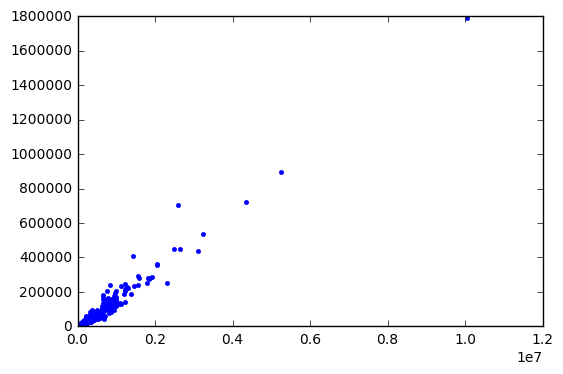

In [9]:
plt.plot(df_16.population, df_16.renter_occupied_households,'.')

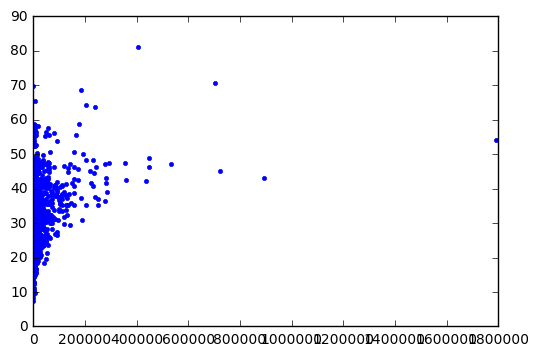

In [10]:
plt.plot(df_16.renter_occupied_households, df_16.pct_renter_occupied,'.')

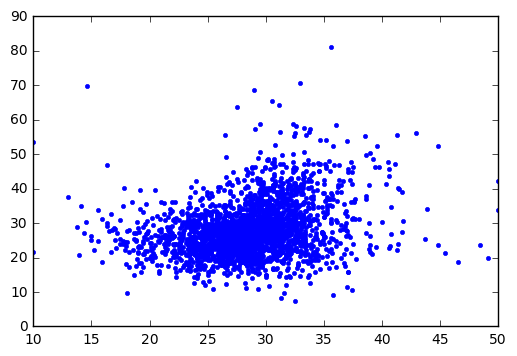

In [11]:
plt.plot(df_16.rent_burden, df_16.pct_renter_occupied,'.')

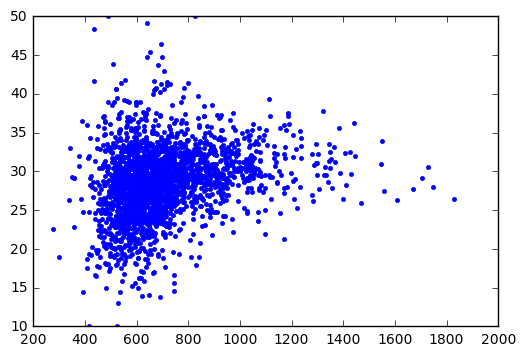

In [12]:
plt.plot(df_16.median_gross_rent, df_16.rent_burden,'.')

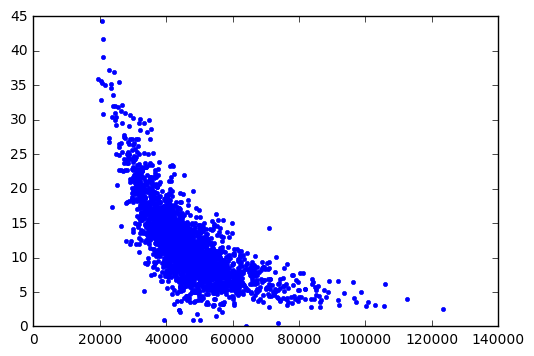

In [13]:
plt.plot(df_16.median_household_income, df_16.poverty_rate, '.')

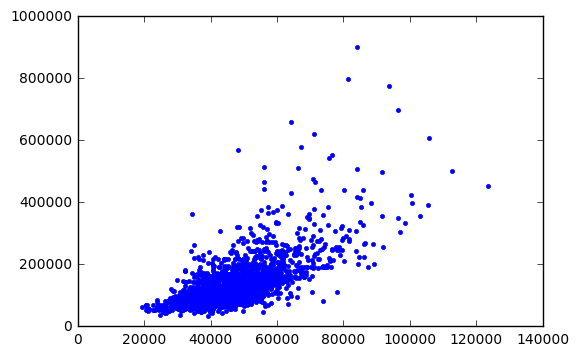

In [14]:
plt.plot(df_16.median_household_income, df_16.median_property_value,'.')

In [15]:
df_16dummy = pd.get_dummies(df_16.parent_location)

In [16]:
df_16norm = pd.DataFrame(preprocessing.normalize(df_16[['poverty_rate','rent_burden','pct_renter_occupied','renter_occupied_households', 'median_gross_rent','median_household_income',\
                                                            'median_property_value']], axis = 0), \
                         columns = ['poverty_rate','rent_burden','pct_renter_occupied','renter_occupied_households','median_gross_rent','median_household_income','median_property_value'])

X = pd.concat([df_16norm, df_16dummy], axis = 1)


In [17]:
df_16.pct_af_am.describe()

count    2493.000000
mean        8.639996
std        14.175599
min         0.000000
25%         0.560000
50%         2.030000
75%         9.550000
max        85.950000
Name: pct_af_am, dtype: float64

In [18]:
y = df_16['pct_af_am']

In [19]:
# model = linear_model.SGDRegressor(loss='squared_epsilon_insensitive', penalty='elasticnet', alpha=0.0001, l1_ratio=0.15,\
#                                   fit_intercept=True,max_iter=6000, tol=None, shuffle=True, verbose=0, epsilon=0.1, \
#                                   random_state=42, learning_rate='invscaling', eta0=0.0001, power_t=0.25, \
#                                   warm_start=False,average=False)

In [20]:
#linear_model.SGDRegressor?
#model = linear_model.LinearRegression()

In [21]:
model = xgb.XGBRegressor(max_depth=6, learning_rate=0.5, n_estimators=100, silent=True, objective='reg:linear',\
                         booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0,\
                         subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, \
                         scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None)

In [22]:

model.fit(X,y)
y_pred = model.predict(X)

metrics.explained_variance_score(y, y_pred)

0.9980999669639864

In [23]:
metrics.r2_score(y, y_pred)

0.998099966863387

(array([845., 524., 223., 128.,  84.,  76.,  65.,  38.,  44.,  34.,  32.,
         35.,  24.,  20.,  29.,  25.,  18.,  25.,  17.,  19.,  20.,  13.,
         17.,  10.,  16.,  11.,  10.,  11.,   9.,   6.,   7.,   4.,   7.,
          5.,   8.,   5.,   2.,   3.,   2.,   1.,   5.,   6.,   1.,   3.,
          2.,   0.,   2.,   0.,   1.,   1.]),
 array([-0.67446256,  1.06186   ,  2.7981825 ,  4.534505  ,  6.2708273 ,
         8.00715   ,  9.743472  , 11.4797945 , 13.216118  , 14.95244   ,
        16.688763  , 18.425085  , 20.161407  , 21.89773   , 23.634052  ,
        25.370375  , 27.106697  , 28.84302   , 30.579342  , 32.315666  ,
        34.051987  , 35.78831   , 37.52463   , 39.260956  , 40.997276  ,
        42.7336    , 44.46992   , 46.206245  , 47.942566  , 49.67889   ,
        51.41521   , 53.151535  , 54.88786   , 56.62418   , 58.360504  ,
        60.096825  , 61.83315   , 63.56947   , 65.30579   , 67.042114  ,
        68.778435  , 70.51476   , 72.25108   , 73.987404  , 75.723724  ,
 

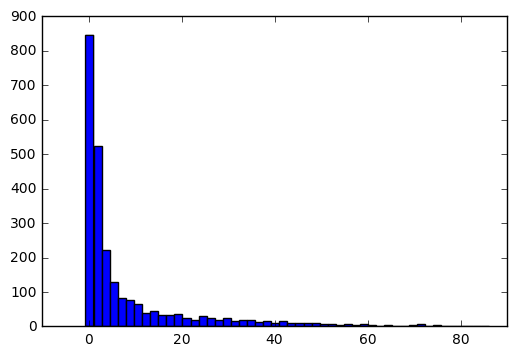

In [24]:
plt.hist(y_pred,bins = 50 )

(array([1.182e+03, 2.820e+02, 1.730e+02, 1.110e+02, 7.400e+01, 7.100e+01,
        6.000e+01, 4.100e+01, 3.700e+01, 2.800e+01, 4.000e+01, 3.300e+01,
        2.100e+01, 2.400e+01, 3.100e+01, 1.700e+01, 2.100e+01, 2.600e+01,
        1.800e+01, 1.900e+01, 1.700e+01, 1.300e+01, 1.900e+01, 7.000e+00,
        1.800e+01, 1.000e+01, 8.000e+00, 9.000e+00, 1.200e+01, 5.000e+00,
        8.000e+00, 2.000e+00, 9.000e+00, 6.000e+00, 6.000e+00, 3.000e+00,
        6.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 7.000e+00,
        2.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00]),
 array([ 0.   ,  1.719,  3.438,  5.157,  6.876,  8.595, 10.314, 12.033,
        13.752, 15.471, 17.19 , 18.909, 20.628, 22.347, 24.066, 25.785,
        27.504, 29.223, 30.942, 32.661, 34.38 , 36.099, 37.818, 39.537,
        41.256, 42.975, 44.694, 46.413, 48.132, 49.851, 51.57 , 53.289,
        55.008, 56.727, 58.446, 60.165, 61.884, 63.603, 65.322, 67.041,
        68.76 , 

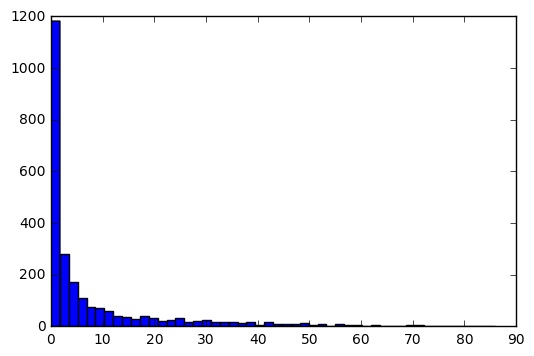

In [25]:
plt.hist(y, bins = 50)

In [26]:
y_pred.size

2493

In [27]:
#bukets width = 5
df_y_pred = pd.DataFrame(y_pred, columns = {'y_pred'})

In [28]:
df_16.reset_index(drop = True, inplace = True)

In [29]:
df_p = pd.concat([df_16, df_y_pred], axis = 1)

array([[1.        , 0.37540872],
       [0.37540872, 1.        ]])

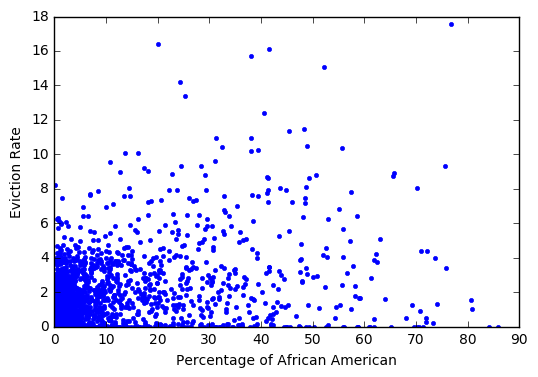

In [30]:
plt.plot(df_p.pct_af_am, df_p.eviction_rate,'.')
plt.xlabel('Percentage of African American')
plt.ylabel('Eviction Rate')
np.corrcoef(df_p.pct_af_am, df_p.eviction_rate)

,pct_af_am,eviction_rate,poverty_rate,rent_burden,median_gross_rent,median_household_income,median_property_value,pct_renter_occupied
pct_af_am,1.0,0.375409,0.509511,0.351527,0.045969,-0.258848,-0.086308,0.306759


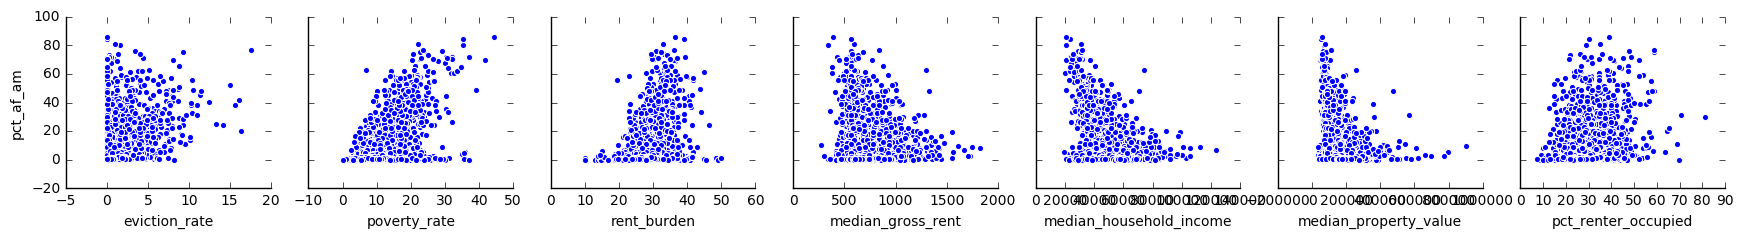

In [31]:
sns.pairplot(data=df_16, x_vars=['eviction_rate','poverty_rate', 'rent_burden', 'median_gross_rent',
       'median_household_income', 'median_property_value', 'pct_renter_occupied'],
                  y_vars=['pct_af_am'])
corr16 = df_16.loc[:,['pct_af_am','eviction_rate','poverty_rate', 'rent_burden', 'median_gross_rent',
       'median_household_income', 'median_property_value', 'pct_renter_occupied']].corr()
corr16.head(1)

# correlation of pct_af_am and eviction rates within buckets

## bucket of predicted pct_af_am of < 1%  has high correlation

## bucket of predicted black-race-percentage <= 0.5

,pct_af_am,eviction_rate,poverty_rate,rent_burden,median_gross_rent,median_household_income,median_property_value,pct_renter_occupied
pct_af_am,1.0,0.18246,0.008721,0.220077,0.055952,0.011716,0.07489,-0.025438


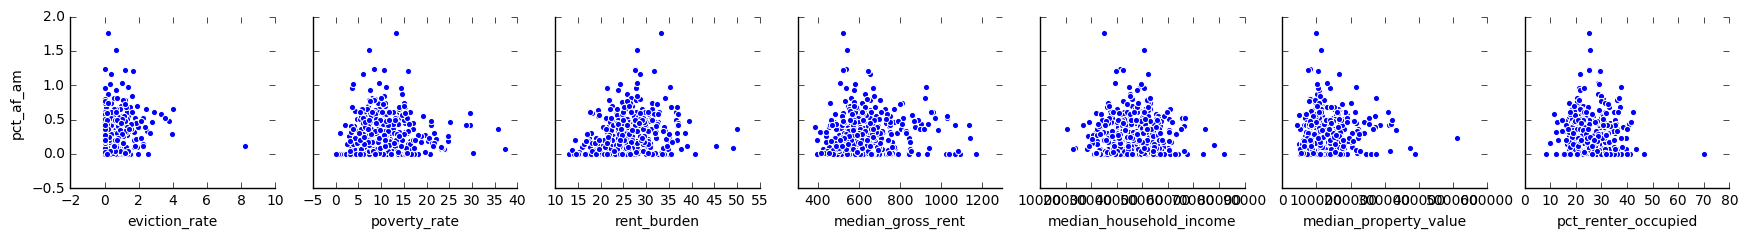

In [32]:
df_16_1 = df_p[(df_p.y_pred <= 0.5)]

sns.pairplot(data=df_16_1, x_vars=['eviction_rate','poverty_rate', 'rent_burden', 'median_gross_rent',
       'median_household_income', 'median_property_value', 'pct_renter_occupied'],
                  y_vars=['pct_af_am'])
corr16_1 = df_16_1.loc[:,['pct_af_am','eviction_rate','poverty_rate', 'rent_burden', 'median_gross_rent',
       'median_household_income', 'median_property_value', 'pct_renter_occupied']].corr()
corr16_1.head(1)

## bucket of predicted black-race-percentage (0.5, 1]

,pct_af_am,eviction_rate,poverty_rate,rent_burden,median_gross_rent,median_household_income,median_property_value,pct_renter_occupied
pct_af_am,1.0,0.111467,-0.021268,0.049321,0.092389,0.093996,0.088923,0.093489


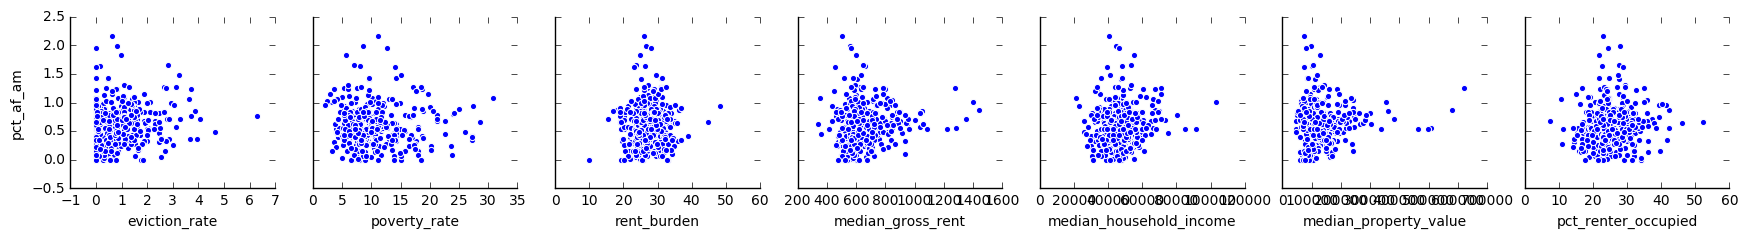

In [33]:
df_16_1 = df_p[(df_p.y_pred > .5) & (df_p.y_pred <= 1)]

sns.pairplot(data=df_16_1, x_vars=['eviction_rate','poverty_rate', 'rent_burden', 'median_gross_rent',
       'median_household_income', 'median_property_value', 'pct_renter_occupied'],
                  y_vars=['pct_af_am'])
corr16_1 = df_16_1.loc[:,['pct_af_am','eviction_rate','poverty_rate', 'rent_burden', 'median_gross_rent',
       'median_household_income', 'median_property_value', 'pct_renter_occupied']].corr()
corr16_1.head(1)

## bucket of predicted black-race-percentage (1, 5]

,pct_af_am,eviction_rate,poverty_rate,rent_burden,median_gross_rent,median_household_income,median_property_value,pct_renter_occupied
pct_af_am,1.0,0.071425,0.048772,0.076011,0.115288,0.036387,0.03845,0.123872


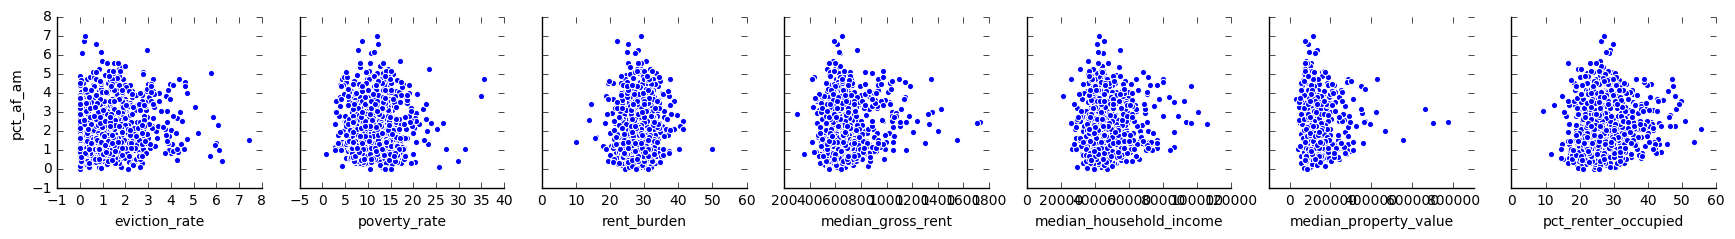

In [34]:
df_16_1 = df_p[(df_p.y_pred > 1) & (df_p.y_pred <= 5)]

sns.pairplot(data=df_16_1, x_vars=['eviction_rate','poverty_rate', 'rent_burden', 'median_gross_rent',
       'median_household_income', 'median_property_value', 'pct_renter_occupied'],
                  y_vars=['pct_af_am'])
corr16_1 = df_16_1.loc[:,['pct_af_am','eviction_rate','poverty_rate', 'rent_burden', 'median_gross_rent',
       'median_household_income', 'median_property_value', 'pct_renter_occupied']].corr()
corr16_1.head(1)

## bucket of predicted black-race-percentage (5, 10]

,pct_af_am,eviction_rate,poverty_rate,rent_burden,median_gross_rent,median_household_income,median_property_value,pct_renter_occupied
pct_af_am,1.0,-0.012172,0.028378,0.046945,-0.006176,-0.019619,-0.00519,-0.017467


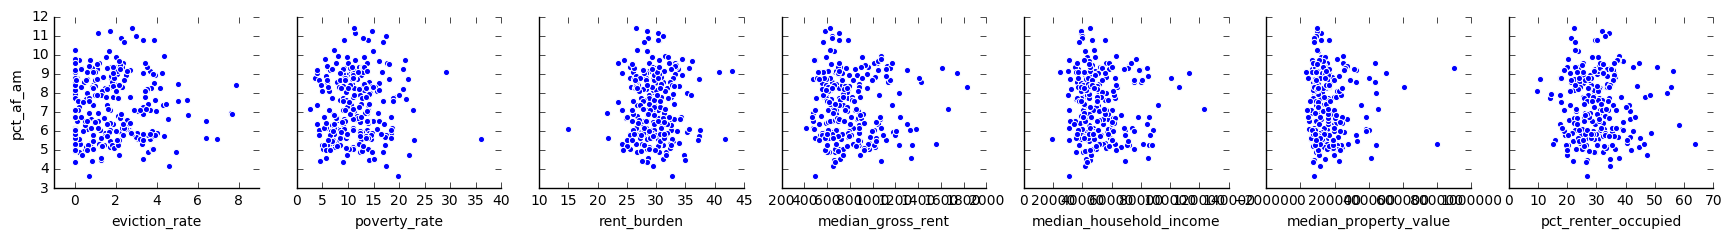

In [35]:
df_16_1 = df_p[(df_p.y_pred > 5) & (df_p.y_pred <= 10)]

sns.pairplot(data=df_16_1, x_vars=['eviction_rate','poverty_rate', 'rent_burden', 'median_gross_rent',
       'median_household_income', 'median_property_value', 'pct_renter_occupied'],
                  y_vars=['pct_af_am'])
corr16_1 = df_16_1.loc[:,['pct_af_am','eviction_rate','poverty_rate', 'rent_burden', 'median_gross_rent',
       'median_household_income', 'median_property_value', 'pct_renter_occupied']].corr()
corr16_1.head(1)

## bucket of predicted black-race-percentage (10, 20]

,pct_af_am,eviction_rate,poverty_rate,rent_burden,median_gross_rent,median_household_income,median_property_value,pct_renter_occupied
pct_af_am,1.0,0.03174,0.044686,-0.043832,0.020172,0.015573,-0.029956,-0.026296


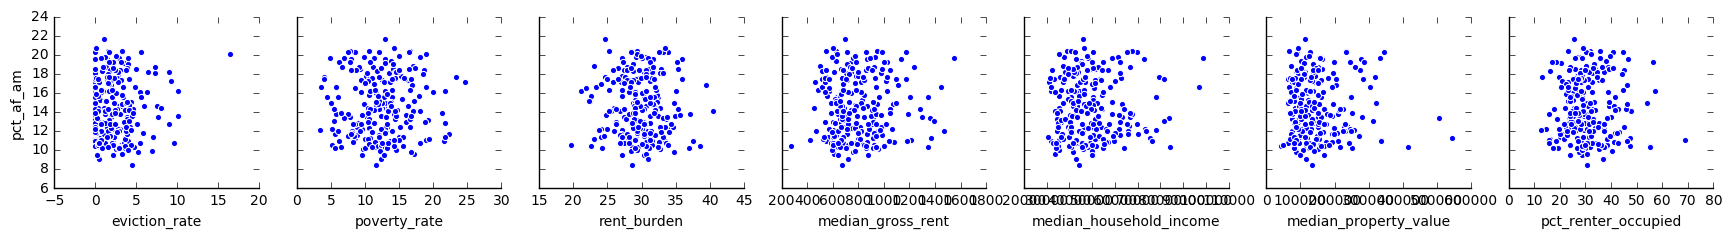

In [36]:
df_16_1 = df_p[(df_p.y_pred > 10) & (df_p.y_pred <= 20)]

sns.pairplot(data=df_16_1, x_vars=['eviction_rate','poverty_rate', 'rent_burden', 'median_gross_rent',
       'median_household_income', 'median_property_value', 'pct_renter_occupied'],
                  y_vars=['pct_af_am'])
corr16_1 = df_16_1.loc[:,['pct_af_am','eviction_rate','poverty_rate', 'rent_burden', 'median_gross_rent',
       'median_household_income', 'median_property_value', 'pct_renter_occupied']].corr()
corr16_1.head(1)

## bucket of predicted black-race-percentage (20,30]

,pct_af_am,eviction_rate,poverty_rate,rent_burden,median_gross_rent,median_household_income,median_property_value,pct_renter_occupied
pct_af_am,1.0,0.053085,0.198821,0.033397,-0.113447,-0.156104,-0.041129,0.052605


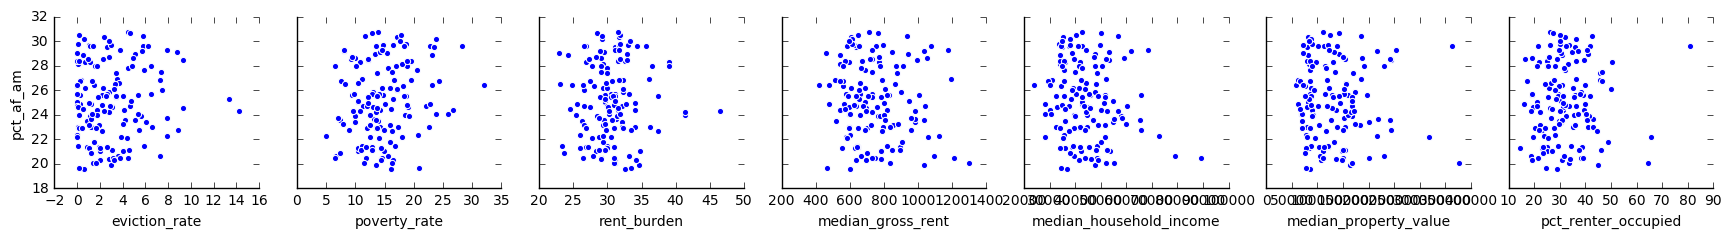

In [37]:

df_16_1 = df_p[(df_p.y_pred > 20) & (df_p.y_pred <= 30)]

sns.pairplot(data=df_16_1, x_vars=['eviction_rate','poverty_rate', 'rent_burden', 'median_gross_rent',
       'median_household_income', 'median_property_value', 'pct_renter_occupied'],
                  y_vars=['pct_af_am'])
corr16_1 = df_16_1.loc[:,['pct_af_am','eviction_rate','poverty_rate', 'rent_burden', 'median_gross_rent',
       'median_household_income', 'median_property_value', 'pct_renter_occupied']].corr()
corr16_1.head(1)

   ## bucket of predicted black-race-percentage (30, 40]  has higher correlation

,pct_af_am,eviction_rate,poverty_rate,rent_burden,median_gross_rent,median_household_income,median_property_value,pct_renter_occupied
pct_af_am,1.0,0.138324,0.125735,0.136189,0.018543,0.018917,-0.003338,0.098692


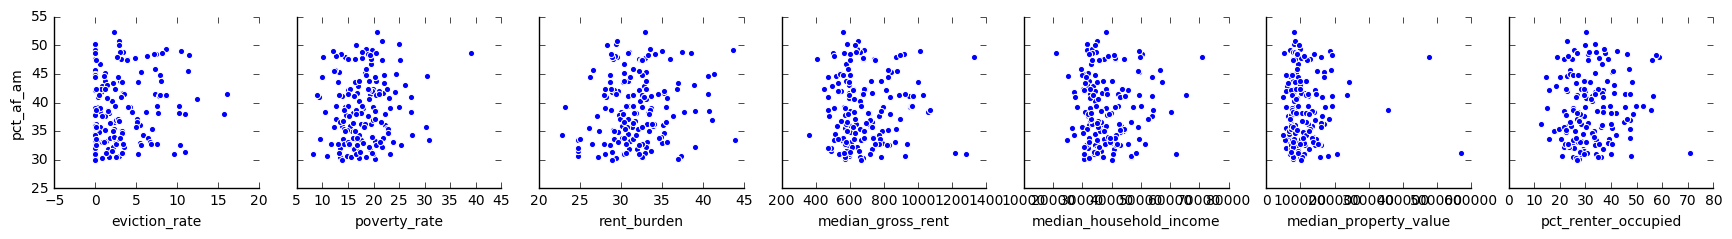

In [38]:
df_16_1 = df_p[(df_p.y_pred > 30) & (df_p.y_pred <= 50)]

sns.pairplot(data=df_16_1, x_vars=['eviction_rate','poverty_rate', 'rent_burden', 'median_gross_rent',
       'median_household_income', 'median_property_value', 'pct_renter_occupied'],
                  y_vars=['pct_af_am'])
corr16_1 = df_16_1.loc[:,['pct_af_am','eviction_rate','poverty_rate', 'rent_burden', 'median_gross_rent',
       'median_household_income', 'median_property_value', 'pct_renter_occupied']].corr()
corr16_1.head(1)

## bucket of predicted black-race-percentage (50,100]

,pct_af_am,eviction_rate,poverty_rate,rent_burden,median_gross_rent,median_household_income,median_property_value,pct_renter_occupied
pct_af_am,1.0,-0.085773,0.554572,0.057938,-0.262841,-0.389609,-0.306734,0.149173


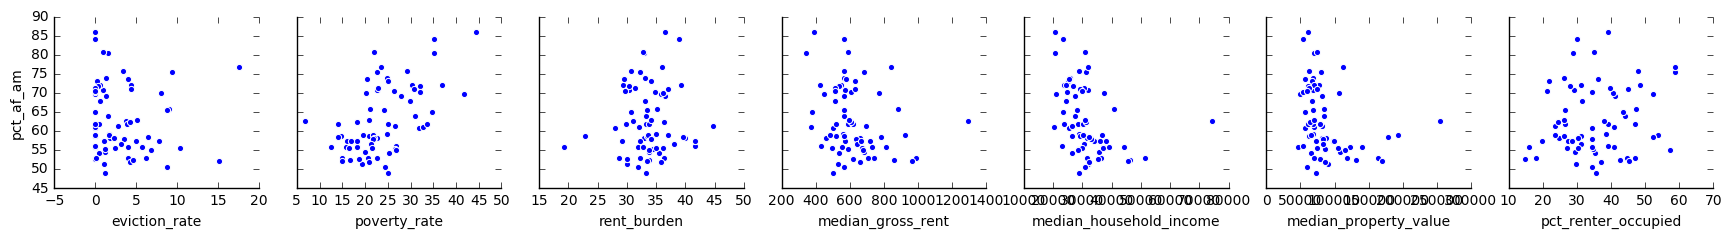

In [39]:
df_16_1 = df_p[(df_p.y_pred > 50)]

sns.pairplot(data=df_16_1, x_vars=['eviction_rate','poverty_rate', 'rent_burden', 'median_gross_rent',
       'median_household_income', 'median_property_value', 'pct_renter_occupied'],
                  y_vars=['pct_af_am'])
corr16_1 = df_16_1.loc[:,['pct_af_am','eviction_rate','poverty_rate', 'rent_burden', 'median_gross_rent',
       'median_household_income', 'median_property_value', 'pct_renter_occupied']].corr()
corr16_1.head(1)